# Flow Matching 2D Unconditional Example

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aurelio-amerio/GenSBI-examples/blob/main/examples/NDE/flow_matching_2d_unconditional.ipynb)

This notebook demonstrates how to train and sample from a flow-matching model on a 2D toy dataset using JAX and Flax. We will cover data generation, model definition, training, sampling, and density estimation using the pipeline utility.

## 1. Environment Setup

In this section, we set up the notebook environment, import required libraries, and configure JAX for CPU or GPU usage.

In [1]:
try: #check if we are using colab, if so install all the required software
    import google.colab
    colab=True
except:
    colab=False

In [2]:
if colab: # you may have to restart the runtime after installing the packages
    %pip install --quiet "gensbi[cuda12] @ git+https://github.com/aurelio-amerio/GenSBI"
    %pip install --quiet "gensbi_examples @ git+https://github.com/aurelio-amerio/GenSBI-examples"
    !git clone --depth 1 https://github.com/aurelio-amerio/GenSBI-examples
    %cd GenSBI-examples/examples/NDE

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.6/199.6 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.2/181.2 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.4/493.4 kB 51.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.8/367.8 kB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 119.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 384.1/384.1 kB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 26.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.0/101.0 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 66.6 MB/s eta 0:00:0000:01:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [3]:
# Set training and model restoration flags
overwrite_model = False
restore_model = False  # Use pretrained model if available
train_model = True  # Set to True to train from scratch

### Library Imports and JAX Backend Selection

In [4]:
# Import libraries and set JAX backend
import os
os.environ['JAX_PLATFORMS']="cuda" # select cpu instead if no gpu is available
# os.environ['JAX_PLATFORMS']="cpu"

from flax import nnx
import jax
import jax.numpy as jnp
import optax
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
from matplotlib import cm

from gensbi_dist import get_gensbi_samples

In [5]:
# Specify the checkpoint directory for saving/restoring models
import orbax.checkpoint as ocp
checkpoint_dir = f"{os.getcwd()}/checkpoints/gensbi_text"

import os
os.makedirs(checkpoint_dir, exist_ok=True)

if overwrite_model:
    checkpoint_dir = ocp.test_utils.erase_and_create_empty(checkpoint_dir)

## 2. Data Generation

We generate a synthetic 2D dataset using JAX. This section defines the data generation functions and visualizes the data distribution.

In [6]:
# Define a function to generate 2D box data using JAX
import jax
import jax.numpy as jnp
from jax import random
from functools import partial
import grain

from gensbi.utils.plotting import transparent_cmap

In [7]:
# # Infinite data generator for training batches
# @partial(jax.jit, static_argnums=[1])  # type: ignore
# def inf_train_gen(key, batch_size: int = 200):
#     x = make_boxes_jax(key, batch_size)

#     return x

batch_size = 256

data = get_gensbi_samples(n_samples=500_000)

train_dataset_grain = (
    grain.MapDataset.source(np.array(data)[...,None])
    .shuffle(42)
    .repeat()
    .to_iter_dataset()
)

performance_config = grain.experimental.pick_performance_config(
            ds=train_dataset_grain,
            ram_budget_mb=1024 * 4,
            max_workers=None,
            max_buffer_size=None,
        )

train_dataset_batched = train_dataset_grain.batch(batch_size).mp_prefetch(
            performance_config.multiprocessing_options
        )

train_iter = iter(train_dataset_batched)

data_val = get_gensbi_samples(n_samples=1_000)

val_dataset_batched = (
    grain.MapDataset.source(np.array(data_val)[...,None])
    .shuffle(42)
    .repeat()
    .to_iter_dataset()
    .batch(512)
)

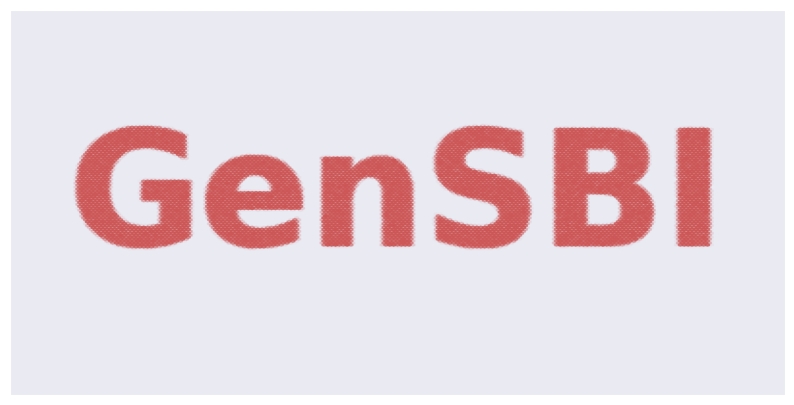

In [24]:
# # Visualize the generated data distribution
samples = np.array(data)

def plot_samples(ax, samples):

    ax.hexbin( 
        samples[:, 0],
        samples[:, 1],
        gridsize=(200, 100),
        cmap=transparent_cmap,
        extent=[-2, 2, -1, 1],
    )

    ax.set_xlim(-2, 2)
    ax.set_ylim(-1, 1)
    #hide axes
    ax.grid(None)
    ax.set_xticks([])
    ax.set_yticks([])

    return ax

fig, ax = plt.subplots(figsize=(10, 5))
plot_samples(ax, samples)
plt.show()

## 3. Model and Loss Definition

We define the velocity field model (an MLP), the loss function, and the optimizer for training the flow-matching model.

In [29]:
# Import flow matching components and utilities
from gensbi.recipes import UnconditionalFlowPipeline
from gensbi.models import Flux1Joint, Flux1JointParams

In [32]:
params = Flux1JointParams(
            in_channels=1,
            vec_in_dim=None,
            mlp_ratio=3.0,
            num_heads=4,
            depth_single_blocks=8,
            val_emb_dim = 10,
            cond_emb_dim=2,
            id_emb_dim=10,
            qkv_bias=True,
            rngs=nnx.Rngs(0),
            dim_joint=2,
            id_merge_mode='concat',
            id_embedding_strategy = "absolute",
            guidance_embed=False,
            param_dtype=jnp.float32,
        )

model = Flux1Joint(params)

In [33]:
training_config = UnconditionalFlowPipeline.get_default_training_config()
training_config["checkpoint_dir"] = checkpoint_dir
training_config["nsteps"] = 30_000


pipeline = UnconditionalFlowPipeline(model,
    train_dataset_batched,
    val_dataset_batched,
    2,
    training_config=training_config)

In [12]:
# Restore the model from checkpoint if requested
if restore_model:
    pipeline.restore_model()

In [34]:
model_params = nnx.state(pipeline.model, nnx.Param)
total_params  = sum(np.prod(x.shape) for x in jax.tree_util.tree_leaves(model_params))
print(f"Total model parameters: {total_params}")

Total model parameters: 859137


## 4. Training Loop

This section defines the training and validation steps, and runs the training loop if enabled. Early stopping and learning rate scheduling are used for efficient training.

In [ ]:
if train_model:
    # Train the model
    pipeline.train(nnx.Rngs(0))

  0%|          | 0/30000 [00:00<?, ?it/s]

## 5. Sampling from the Model

In this section, we sample trajectories from the trained flow-matching model and visualize the results at different time steps.

### sample the model

In [25]:
key = jax.random.PRNGKey(42)
T = jnp.linspace(0,1,10)  # sample times
sol = pipeline.sample(key, nsamples=500_000, time_grid=T)

In [27]:
sol.shape

(10, 500000, 2, 1)

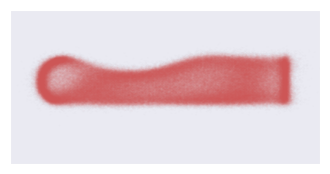

In [28]:
fig, ax = plt.subplots(figsize=(4, 2))
plot_samples(ax, np.array(sol[-1,...,0]))
plt.show()

## 6. Marginal and Trajectory Visualization

We visualize the marginal distributions and sample trajectories from the model.

In [17]:
# Import plotting utility for marginals
from gensbi.utils.plotting import plot_marginals

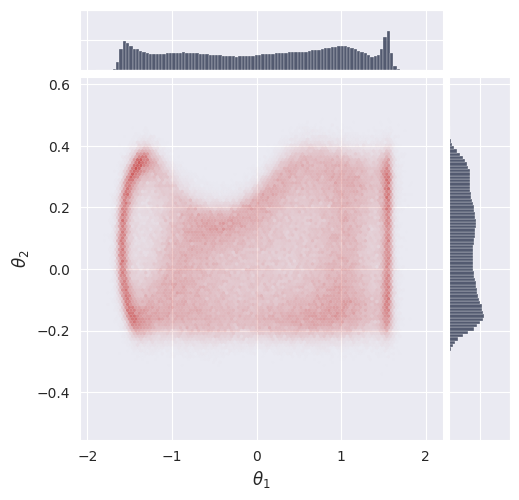

In [18]:
# Plot the marginal distribution of the final samples
plot_marginals(sol[-1,...,0], plot_levels=False, gridsize=100, backend="seaborn")
plt.show()

In [19]:
# Sample and visualize trajectories with finer time resolution
batch_size = 1000
T = jnp.linspace(0,1,50)  # sample times

sol = pipeline.sample(key, nsamples=batch_size, time_grid=T)

In [20]:
# Import plotting utility for trajectories
from gensbi.utils.plotting import plot_trajectories

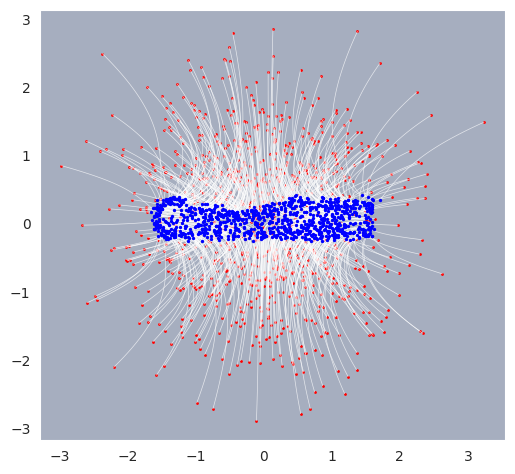

In [21]:
# Plot sampled trajectories
fig, ax = plot_trajectories(sol[...,0])
plt.grid(False)
plt.show()